<a href="https://colab.research.google.com/github/utkarshsharma1/jax-tutorial/blob/main/src/Jax_tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is about my exploration on learning JAX.

I am referring this [playlist](https://youtu.be/SstuvS-tVc0?si=wCkaDfZdIpM4A0oO) by Aleksa Gordic.

In [ ]:
# importing jax as numpy
import jax.numpy as jnp
import numpy as np

# some transformation functions
from jax import grad, jit, vmap, pmap

# lax is for
from jax import lax

from jax import make_jaxpr, random, device_put
import matplotlib.pyplot as plt

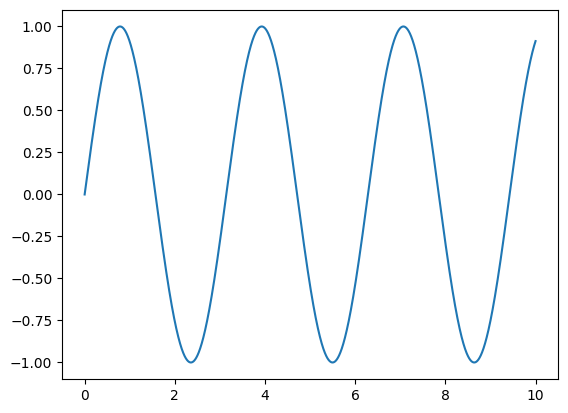

In [ ]:
x_np = np.linspace(0, 10, 5000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)
plt.show()

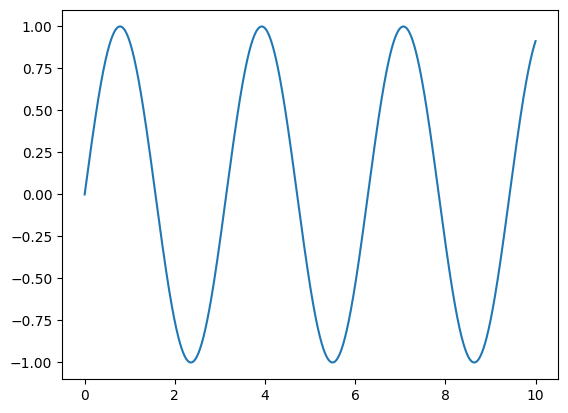

In [ ]:
x_np = jnp.linspace(0, 10, 5000)
y_np = 2 * jnp.sin(x_np) * jnp.cos(x_np)
plt.plot(x_np, y_np)
plt.show()

In [ ]:
# JAX arrays are immutable, functional programming
x = jnp.array([1, 2, 3])
x[0] = 10

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
# Solution create a new array
x = jnp.array([1, 2, 3])
y = x.at[0].set(10)
print(x)
print(y)

[1 2 3]
[10  2  3]


In [ ]:
seed = 43
key = random.PRNGKey(seed)

x = random.normal(key, (10,))
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [ 0.07520543  0.1719244   0.8410886  -0.58373314 -0.11038122 -1.5184603
  1.1545978   0.25870752 -0.04551325 -0.35830256]


`jaxlib.xla_extension.ArrayImpl` is the core array type used in JAX. It represents an array that resides on an accelerator device (like a GPU or TPU) and is optimized for performance by JAX's XLA (Accelerated Linear Algebra) compiler. It's similar to NumPy arrays but is immutable and designed for efficient execution on hardware accelerators.

In [ ]:
# Accelerator agnostic
size = 3000

x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit np.dot(x_np, x_np.T)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()


12.3 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
340 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.3 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The output shows that JAX is significantly faster than NumPy for this matrix multiplication task, especially when the data is already on the accelerator device.

In [ ]:
def visualize_fn(fn, l=-10, r=10, n=1000):
  x = jnp.linspace(l, r, n)
  plt.plot(x, fn(x))
  plt.show()

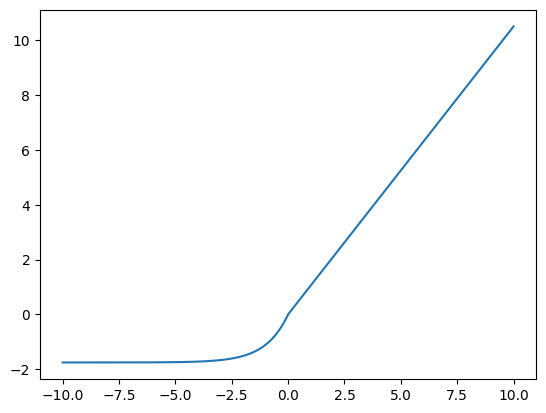

non jit version
1.04 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
jit version
131 µs ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# JIT property

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)

visualize_fn(selu)

data = random.normal(key, (100000))

print("non jit version")
%timeit selu(data).block_until_ready()

print("jit version")
%timeit selu_jit(data).block_until_ready()


In [ ]:
# auto diff using GRAD

def sum_logistic(x):
  # return jnp.sum(1.0 / (1.0 + jnp.exp(-1)))
  return jnp.sum(x ** 2)

x = jnp.arange(3.)
print(x)
loss = sum_logistic

grad_loss = grad(loss)

print(grad_loss(x))

[0. 1. 2.]
[0. 2. 4.]


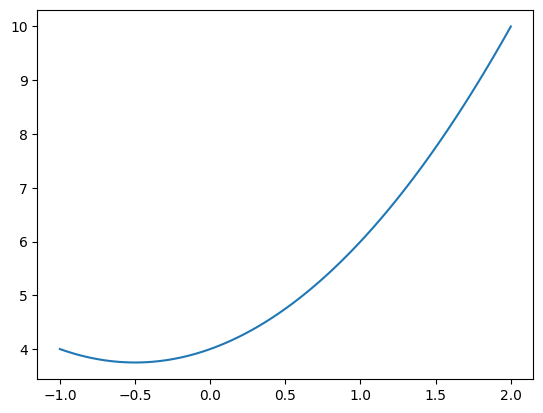

3.0
2.0
0.0


In [ ]:
x = y = 1.

f = lambda x: x**2 + x + 4
visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)
df2dx = grad(dfdx)
df3dx = grad(df2dx)

print(dfdx(x))
print(df2dx(x))
print(df3dx(x))

In [ ]:
# derivative wrt y
f = lambda x, y: x**2 + x + 4 + y**2

dfdx = grad(f, argnums=0)
dfdy = grad(f, argnums=1)

print(dfdx(x, y))
print(dfdy(x, y))

3.0
2.0


In [ ]:
# Auto diff another powerful example
from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2 # paraboloid
